In [1]:
# This is a handy extension when using and debuging external modules.
# Normally the notebook kernel load the module only once. If we make any changes in the module and want to see them 
# we have to restart the kernel. Setting autoreload to 2 forces kernel to reaload. all modules before running the code.
# (see https://ipython.org/ipython-doc/stable/config/extensions/autoreload.html)

%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
%matplotlib inline
plt.rcParams["figure.figsize"] = [12,8]
import pandas as pd

In [3]:
# Adds repo root dir to python system path used to search for packages 
# and modules. This enables  loading modules from mchlearn package provided
# in this repo. 
import sys
sys.path.append('../..') 

# Calibration

So far we have tried hard to estimate the probability of examplar belonging to class $c$ given the features $x$

$$P(C = c|X=x)$$

but  we have not really made use of the fact that this is a probability.  We have treated the output of the classifier as a _score_ that we  have used for thresholding. While the ultimate goal of the classfier is to  classify,  we can treat the probabilistic classifiers presented so far as doing _regression_  by learning the probability function and instead of measuring solely the   classification performance we  can also ask how well is the classifier predicting the  probabilities? 

This is a question about the _calibration_ of the classifier. Let me illustrate this on the example of weather prediction. When discussing the probability calculus at  the begining of those lectures I have stated that it's problematic to give exact meaning to the statement that e.g. "the probability of rain tomorrow is 25%". Historically we can however check the  calibration of the predictor as follow: we look at all days where "25% of rain" was forecasted. If the forecast is well calibrated we should see rain in about 25% of the cases. We can perform this check for  other values of the rain forecast. If we plot the real observed fraction of rainy days against the predicted value we obtain the _calibration curve_ or _reliability diagram_. If the forecast is well calibrated the points should lie on the $y=x$ diagonal line. 

As I do not have any historical weather forecast data, I will illustrate this on our height and weight example. I will start by loading the dataset and training the  quadratic discriminative analiser classifier that discussed in the  previous notebook. 

In [4]:
# I have added a helper function to mchlearn package that loads the HW data, performs units conversion and adds BMI
from mchlearn.datasets import load_height_weight

data = load_height_weight('../../Data/HeightWeight/weight-height.csv')

In [5]:
data.head(3)

,Gender,Height,Weight,BMI
0,Male,1.875714,109.577784,31.145060
1,Male,1.747060,73.526644,24.089563
2,Male,1.882397,96.371608,27.197364


As always we will split the data into training and testing sets

In [6]:
from sklearn.model_selection import  train_test_split
seed = 77678  #By fixing the seed we guarantee that we can split the set in same way each time this maybe handy for debuging purposes
train_data, test_data  = train_test_split(data,test_size=0.25, random_state=seed)

In [7]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [8]:
qda =  QuadraticDiscriminantAnalysis()

In [9]:
qda.fit(train_data[['Height','Weight']], train_data.Gender=='Female')

QuadraticDiscriminantAnalysis()

In [10]:
test_predicted_proba = qda.predict_proba(test_data[['Height', 'Weight']])[:,1] 

In [11]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

In [12]:
pd.DataFrame(confusion_matrix(test_data.Gender=='Female', test_predicted_proba>0.5, normalize='true')) 

,0,1
0,0.914489,0.085511
1,0.084883,0.915117


Let's plot the ROC curve

In [13]:
from mchlearn.plotting import roc_plot, add_roc_curve

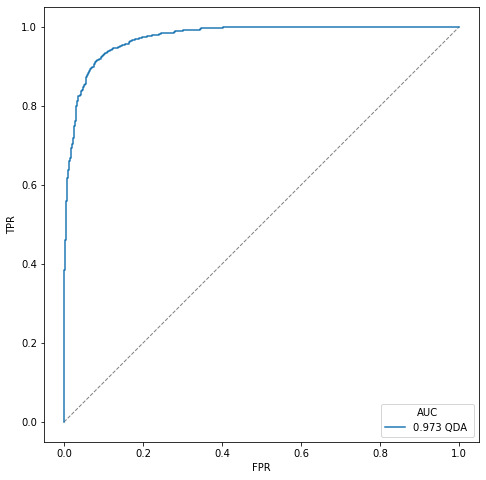

In [14]:
fig, ax = roc_plot()
add_roc_curve(test_data.Gender=='Female', test_predicted_proba, "QDA", ax=ax)
ax.legend(title='AUC');

Please notice that the  ROC curve does not depend on the fact that classifier returns a probability! All  what is needed is a _score_ value , such that a bigger score indicates bigger chance of positive examplar. The ROC curve will not change if we transform the value returned from classifier by any monoticaly  increasing function: 

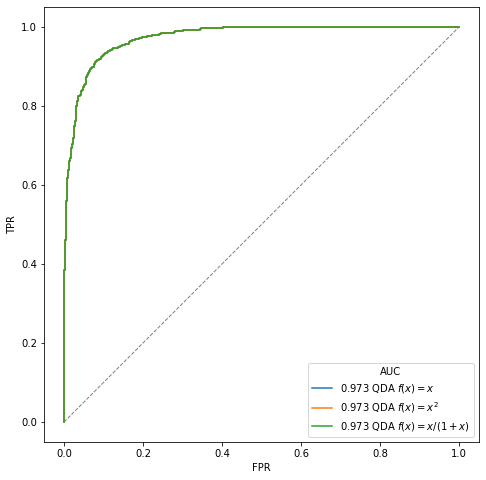

In [15]:
fig, ax = roc_plot()
add_roc_curve(test_data.Gender=='Female', test_predicted_proba, "QDA $f(x)=x$", ax=ax)
add_roc_curve(test_data.Gender=='Female', test_predicted_proba**2, "QDA $f(x)=x^2$", ax=ax)
add_roc_curve(test_data.Gender=='Female', test_predicted_proba/(1+test_predicted_proba), "QDA $f(x)=x/(1+x)$", ax=ax)
ax.legend(title='AUC');

As you can see the  all the curves are identical.

## Calibration curves

So how can we test that the classifier returns a probability? As the probability is a continous variable, we cannot check all the possible prediction values. We must first somehow discretize it by  dividing  possible values into a number of bins. Let's divide the probability space in 20 uniform bins and see how the output of the classifier is distributed by plotting a histogram

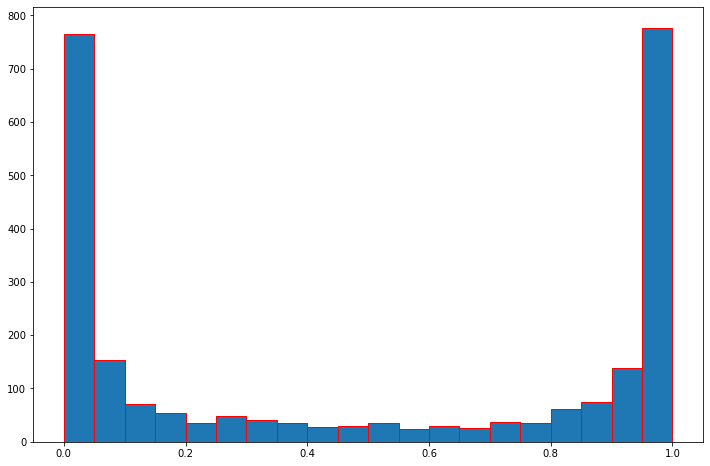

In [16]:
counts, edges, _ = plt.hist(test_predicted_proba, bins=np.linspace(0,1,21), edgecolor='red');

As we can see most in most of the cases the classifier is pretty sure, the scores are concentrated close to zero and one, however the examples are not uniformly distributed in the bins, especially the outer ones:

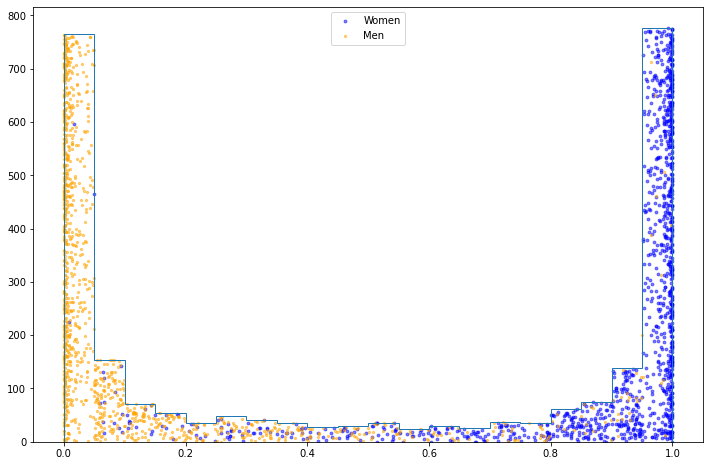

In [17]:
# Plots all test data points inside  the histogram. The x value is the predicted probability, the y value is uniform random in the range = [0, bin_height).
bins = np.digitize(test_predicted_proba, bins=edges).astype('int32')
ys = counts[bins-1]*np.random.uniform(0,1,size = len(test_predicted_proba))
women = test_data.Gender=='Female'
men = test_data.Gender=='Male'
plt.scatter(test_predicted_proba[women], ys[women], s=8, alpha = 0.5, c='blue', label='Women')
plt.scatter(test_predicted_proba[men], ys[men], s=5, alpha = 0.5, c= 'orange', label ='Men')
counts, edges, _ = plt.hist(test_predicted_proba, bins=np.linspace(0,1,21), histtype='step');
plt.legend();

We will now look at our cases bin by bin. For each bin the observed probability is the number of positive examples (women) in the bin. As the  predicted value we will take the mean of all predicited probabilities contained in the bin. This in general will not be equal to the bin center as you can see from the  plot above.

I have implemented this in the function below. I  have also added error estimates for both observed (true)  and predicted probability. 

In [18]:
import pandas.core.series
def reliability_diagram1(y_true, y_proba, bins):
    # If bins is a list or numpy array uses it as bin edges. If not it assumes that it is an integer
    # and  uses bins number of bins of the same width in the range [0,1)
    edges = bins if isinstance(bins,(list, np.ndarray)) else np.linspace(0,1,bins+1)
    n_bins = len(edges)-1
    
    # If y_true is a pandas Series it converts it to numpy array. 
    true_values = y_true.values if isinstance(y_true, pandas.core.series.Series) else y_true
    
    #Takes the the array of probabilities y_proba and returns the bin corresponding number
    #Bin index 0 indicates values smaller the zero (should not happen!)
    #Bin index n_bins+1 indicates values greater or equal to 1.0 (can happen)
    prob_bins = np.digitize(y_proba, bins=edges).astype('int32')
    
    #arrays that will accumulate counts in the bins (two more bins for bin 0 and n_bins+1)
    total = np.zeros(n_bins+2)
    positive  = np.zeros(n_bins+2)
    bin_mean  = np.zeros(n_bins+2)
    bin_mean2 = np.zeros(n_bins+2)
    # accumulation loop
    for i,p in enumerate(y_proba):
        bin_index = prob_bins[i]
        total[bin_index]    += 1
        positive[bin_index] += true_values[i]
        bin_mean[bin_index] += p
        bin_mean2[bin_index] += p*p #needed for mean variance calculations. 
    
    #taking only non empty bins
    non_empty = (total>0)
    ne_total  = total[non_empty]
    p_true = positive[non_empty]/ne_total 
    p_pred = bin_mean[non_empty]/ne_total 
    p_pred2 =  bin_mean2[non_empty]/ne_total 
    
    #Error estimates (samples standard deviation)
    e_true = np.sqrt(np.clip(p_true*(1-p_true),0,None)/ne_total)
    e_pred =  np.sqrt(np.clip(p_pred2-p_pred*p_pred,0,None)/ne_total)
    
    return  p_true, p_pred, e_true,  e_pred

And here are some more helper functions for plotting the calibration curves

In [19]:
def reliability_diagram_plot(**kwargs):
    """
    Returns the fig and ax objects for a aspect 1 plot with predefined axes labels and
    diagonal line for plotting the reliability diagram (calibration curve)
    """
    fig, ax = plt.subplots(**kwargs)
    ax.set_aspect(1)
    ax.set_ylabel('p observed')
    ax.set_xlabel('p predicted')
    ax.plot([0,1],[0,1], linewidth=1, linestyle='--', color = 'grey');
    return fig, ax

def add_reliability_diagram(p_pred, p_true,  e_pred=None, e_true=None, color ='blue', ax=None, **kwargs):
    """
    Plots the  reliability diagram given by p_pred, p_true,  e_pred, e_true on the given axes. If axis is not 
    given it uses the current Axes instance.
    """
    if not ax:
        ax = plt.gca()
    ax.scatter(p_true,p_pred, facecolor = 'white', edgecolor = color, zorder = 10, **kwargs)
    if not (e_pred is None):
        ax.errorbar(p_true,p_pred, yerr = e_pred, fmt = 'none', ecolor=color, capsize=4, elinewidth=1)    
    if not (e_true is None):
        ax.errorbar(p_true,p_pred, xerr = e_true, fmt = 'none', ecolor=color, capsize=4, elinewidth=1)        

And finally here is our calibration plot:

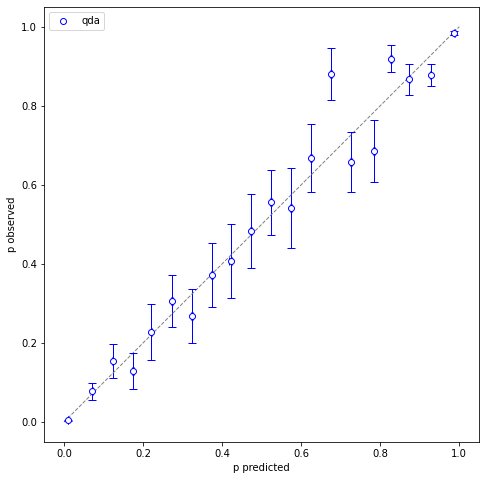

In [20]:
qda_test_rd =  reliability_diagram1(test_data.Gender=='Female', test_predicted_proba, 20)

fig, ax = reliability_diagram_plot()
#The * notation 'splices' the array into function arguments i.e. f(*[a,b,c]) = f(a,b,c)
add_reliability_diagram(*qda_test_rd, ax = ax, label='qda')
ax.legend();

As you can see  it look rather well calibrated, especially considering the errors.

Maybe now is the time to  mention that such function as above  is already provided in the scikit-learn library (minus the errors) ...

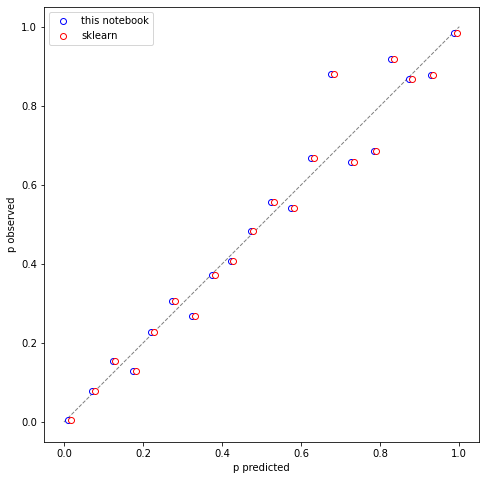

In [21]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(test_data.Gender == 'Female',qda.predict_proba(test_data[['Height','Weight']])[:,1], n_bins=20)

fig, ax = reliability_diagram_plot()
add_reliability_diagram(*qda_test_rd[:2], color='blue', label ='this notebook')
add_reliability_diagram( prob_true, prob_pred+0.007,    color='red', label='sklearn')
ax.legend();

As you can see the results are exactly the same (I have shifted points slightly to make them distinct). 

### Quantile bins

Because the distribution of entries in the bins is not uniform as we could see on the histogram above, we can consider divide the interval $[0,1)$  in such a way that each bin contains approximatelly same number of entries. The function below generates such partitioning

In [22]:
def equiprobable_bins(proba, n_bins):
    """
    Quick and dirty: uses the numpy.array_split function that divides array in n
    almost equal arrays. We only need to adjust the end points to zero and one.
    """
    sorted_proba = np.sort(proba)
    split = np.array_split(sorted_proba,n_bins)
    mins = [a[-1] for a in split]
    edges = np.asarray([0]+mins)
    edges[-1]=1.0
    return edges


and we can check that indeed it works

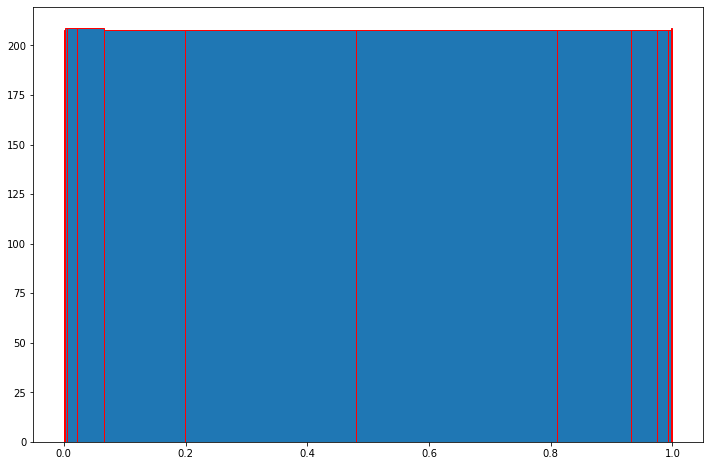

In [23]:
plt.hist(test_predicted_proba, bins=equiprobable_bins(test_predicted_proba, 12), edgecolor='red');

the histogram is flat but the bins have differentwidth.

If we use this partitioning for the calibration plot we get a much nicer picture

In [24]:
qda_test_q_rd= reliability_diagram1(test_data.Gender=='Female', test_predicted_proba, bins=equiprobable_bins(test_predicted_proba, 12))

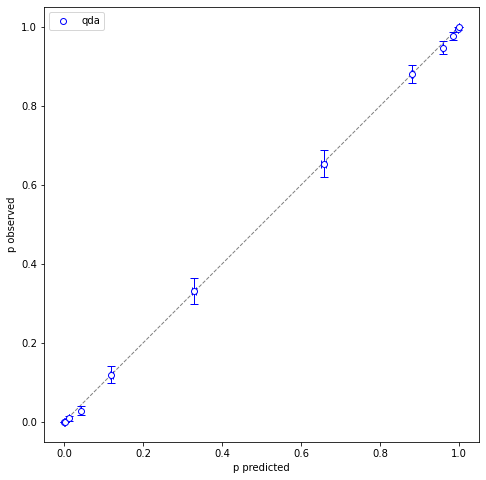

In [25]:
fig, ax = reliability_diagram_plot()
add_reliability_diagram(*qda_test_q_rd, ax = ax, label='qda')
ax.legend();

To make my function mimick the built if function `calibration_plot` I will slightly change the interface of the `reliability_diagram` function:

In [26]:
import pandas.core.series
def reliability_diagram(y_true, y_proba, n_bins, strategy = 'uniform'):
    if strategy == 'uniform':
        edges =p.linspace(0,1,bins+1) #uniform bins
    elif strategy ==  'quantile':
         edges = equiprobable_bins(y_proba, n_bins) #same number of points in bin
    else:
        raise ValueError("strategy argument got an unexpected value '{:s}'".format(strategy))
    
    # rest is unchanged
    true_values = y_true.values if isinstance(y_true, pandas.core.series.Series) else y_true
    prob_bins = np.digitize(y_proba, bins=edges).astype('int32')
    total = np.zeros(n_bins+2)
    positive  = np.zeros(n_bins+2)
    bin_mean  = np.zeros(n_bins+2)
    bin_mean2 = np.zeros(n_bins+2)
    for i,p in enumerate(y_proba):
        bin_index = prob_bins[i]
        total[bin_index]    += 1
        positive[bin_index] += true_values[i]
        bin_mean[bin_index] += p
        bin_mean2[bin_index] += p*p
        
    non_empty = (total>0)
    ne_total = total[non_empty]
    p_true = positive[non_empty]/ne_total 
    p_pred = bin_mean[non_empty]/ne_total 
    p_pred2 =  bin_mean2[non_empty]/ne_total 
    e_true = np.sqrt(np.clip(p_true*(1-p_true),0,None)/ne_total)
    e_pred =  np.sqrt(np.clip(p_pred2-p_pred*p_pred,0,None)/ne_total)
    return  p_true, p_pred, e_true,  e_pred

## Brier score

While the calibration curve gives a detailed picture of the predictor performance it can be summarized by so called [Brier score](https://en.wikipedia.org/wiki/Brier_score)

$$\frac{1}{N}\sum_{i=1}^N\left(o_i- p(x_i)\right)^2, \quad o_i=0,1$$

where $o_i$ is the actual (real) result (0 or 1) and $p(x_i)$ is the predicted probability. The sum is over all data examples.

#### Problem

What values can the the Brier score take? When is it maximum? When it is minimum?

To see how it works consider the case where $p(x_i)$ can take only a finite number of values $p_j, j =1,\ldots,K$. We can split the sum into $K$ parts, each part $j$ corresponding to examples where classifier predicted probability $p_j$:

$$p(x_j)=p_j,\quad j =1,\ldots,K$$

$$\frac{1}{N}\sum_{j=1}^K \sum_{i=1}^{N_j}\left(o_{ji}- p_j\right)^2
=\frac{1}{N}\sum_{j=1}^K \sum_{i=1}^{N_j}\left(o_{ji}^2-2 o_{ji} p_j+ p_j^2\right)
=\frac{1}{N}\sum_{j=1}^K N_j \left(\overline{o_j^2}-2 \bar{o}_{j} p_j+ p_j^2\right)$$

$$\bar{o}_{j}\equiv \frac{1}{N_j}\sum_{i=1}^{N_j}o_{ji}=\tilde{p}_j$$

$$o_{ji}^2=o_{ji},\quad \overline{o_j^2}=\bar{o}_j\quad $$

$N_j$ is the number of entries in group $j$. In the last equation we  have used the fact that $o_{ij}=0,1$ so $o_{ji}^2=o_{ji}$.  For the same  reason the  average

is the observed frequncy of positive examples in group $j$.  Putting this all togheter we finally obtain for the Brier score

$$\frac{1}{N}\sum_{j=1}^K N_j \left(\tilde{p}_j- p_j\right)^2=\sum_{j=1}^K \tilde{\pi}_j \left(\tilde{p}_j- p_j\right)^2$$

It is now clear that it measures the discrepancy between predicted and observed frequency. 

So let's check what is the value of Brier score for our QDA classifier

In [27]:
np.mean((test_predicted_proba-(test_data.Gender=='Female'))**2)

0.06359696364853558

By now you can probably guess that a suitable function is also provided by the scikit-learn library

In [28]:
from sklearn.metrics import brier_score_loss
brier_score_loss(test_data.Gender=='Female', test_predicted_proba)

0.06359696364853558

The function has a suffix 'loss' which indicates that smaller the value, the better the classifier.

## Naive Bayes

Now let's try  Naive Bayes classifier. As Naive Bayes makes strong independency assumptions which  definitelly are not satisfied in our case (height  and weight are clearly strongly correlated), we can expect that the probabilities are wrong.  Let's check if it shows in the calibration curves

In [29]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(train_data[['Height', 'Weight']], train_data.Gender=='Female')
nb_test_predicted_proba = nb.predict_proba(test_data[['Height', 'Weight']])[:,1]

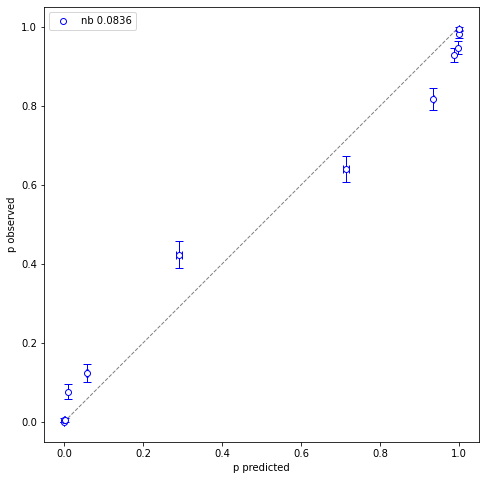

In [30]:
nb_test_q_rd = reliability_diagram(test_data.Gender=='Female', nb_test_predicted_proba, n_bins=12, strategy='quantile')
fig, ax = reliability_diagram_plot()
brier_nb = brier_score_loss(test_data.Gender=='Female', nb_test_predicted_proba)
add_reliability_diagram( *nb_test_q_rd, ax = ax, label='nb {:.4f}'.format(brier_nb) )
ax.legend();

We see a characteristic inverted sigmoid function kind of shape. But observe that the Brier score is still quite low. That is because most of the data points are concetrated around probability zero or one where the predictions are quite accurate. 

## Calibrating a classifier

$$p_c(x) = f(p(x))$$

Can we correct or _calibrate_ the classifier ? Looking at the reliability diagrams we may think that we could adjust the probabilities output by classifier to correct for miss calibration and indeed this can be done with sufficient data. The simplest method is the _histogram_ method. We take a function that is piecewise constant over each bins that were used to plot the calibration curve. The  value in the bin is the true positive examples frequency in that bin. Thist will correct  the calibration plot _exactly_ (as long as we use same bins). Functions below calculates the correction

In [31]:
import pandas.core.series
#This is a partial repetition of the reliability diagram function
def bined_positive_freq(y_true, y_proba, n_bins, strategy = 'uniform'):
    if strategy == 'uniform':
        edges =p.linspace(0,1,bins+1)
    elif strategy ==  'quantile':
         edges = equiprobable_bins(y_proba, n_bins)
    else:
        raise ValueError("strategy argument got an unexpected value '{:s}'".format(strategy))
    
    
    true_values = y_true.values if isinstance(y_true, pandas.core.series.Series) else y_true
    prob_bins = np.digitize(y_proba, bins=edges).astype('int32')
    total = np.zeros(n_bins+2)
    positive  = np.zeros(n_bins+2)
    for i,p in enumerate(y_proba):
        bin_index = prob_bins[i]
        total[bin_index]    += 1
        positive[bin_index] += true_values[i]
        
    p_true = positive/np.clip(total,1,None)#we are  returning all the bins so we must make sure we are not dividing by zero
    
    return  p_true, edges

def make_correction(p_true, bins):
    def correction(p):
        i = np.digitize(p, bins).astype('int32')
        return p_true[i]
    
    return correction


def calibration_function(y_true, y_proba, n_bins, strategy = 'quantile'):
    p_true, edges = bined_positive_freq(y_true, y_proba, n_bins, strategy)
    
    return make_correction(p_true, edges)
    

In [32]:
f = calibration_function(test_data.Gender=='Female', nb_test_predicted_proba, n_bins=12)

Resulting in a function mimicking the calibration plot

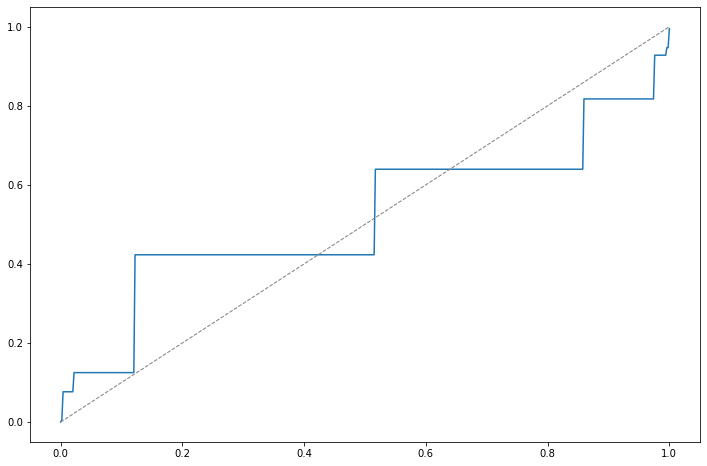

In [33]:
ps = np.linspace(0,0.99999,500) # value one falls outside the bins ... 
plt.plot(ps, f(ps))
plt.plot([0,1],[0,1], color ='grey', linewidth=1, linestyle='--')

After corrections the classifier is calibrated perfectly

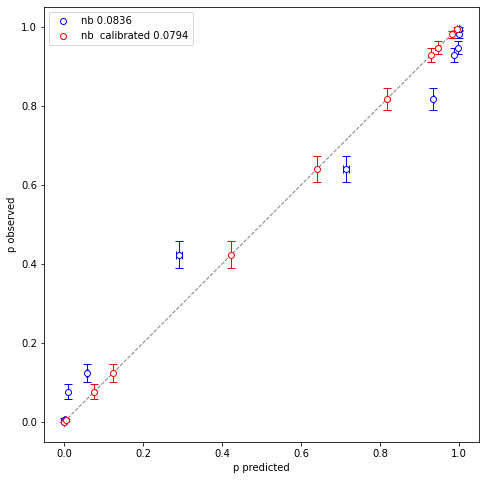

In [34]:
nb_test_predicted_proba_cal = f(nb_test_predicted_proba)
nb_test_q_rd_calibrated = reliability_diagram(test_data.Gender=='Female', nb_test_predicted_proba_cal, n_bins=12, strategy='quantile')
fig, ax = reliability_diagram_plot()
brier_nb_cal = brier_score_loss(test_data.Gender=='Female', nb_test_predicted_proba_cal)
add_reliability_diagram(*nb_test_q_rd, ax = ax, label='nb {:.4f}'.format(brier_nb) )
add_reliability_diagram(*nb_test_q_rd_calibrated, ax = ax, label='nb  calibrated {:.4f}'.format(brier_nb_cal), color='red' )
ax.legend();

This is however not the right approach, this is cheating! The classifier was calibrated on the same date we used to test it.
The proper way is to use different sets for training, calibrating and finally testing. We will use our training set and split it into two sets

In [35]:
train_data2, calibration_data = train_test_split(train_data, train_size=0.75, random_state = seed)

and use it to train a new Naive Bayes classifier

In [36]:
nb_cal = GaussianNB()
nb_cal.fit(train_data2[['Height', 'Weight']], train_data2.Gender=='Female')

GaussianNB()

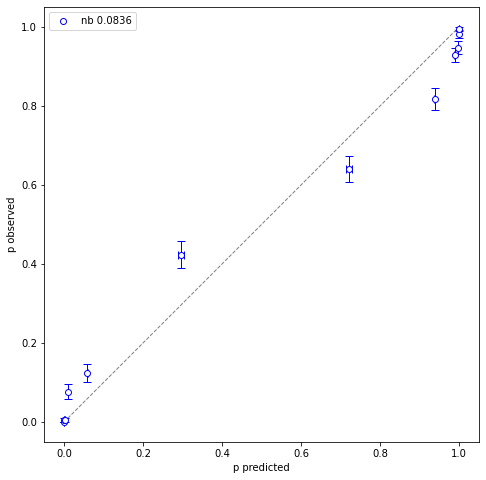

In [37]:
nb_cal_test_predicted_proba = nb_cal.predict_proba(test_data[['Height', 'Weight']])[:,1]
nb_cal_test_q_rd = reliability_diagram(test_data.Gender=='Female', 
                                                                     nb_cal_test_predicted_proba, 
                                                                     n_bins=12, strategy='quantile')
                                                                    
fig, ax = reliability_diagram_plot()
brier_nb = brier_score_loss(test_data.Gender=='Female', nb_test_predicted_proba)
add_reliability_diagram(*nb_cal_test_q_rd, ax = ax, label='nb {:.4f}'.format(brier_nb) )
ax.legend();

As we can see this classifier exhibits similar miss-calibration as before. We will use the calibration data for  calculating the correction

In [38]:
nb_cal_calibration_predicted_proba = nb_cal.predict_proba(calibration_data[['Height', 'Weight']])[:,1]

In [39]:
nb_cal_calibration_q_rd = reliability_diagram(calibration_data.Gender=='Female', nb_cal_calibration_predicted_proba,
                                                                                 n_bins=12, strategy='quantile')

In [40]:
brier_nb = brier_score_loss(test_data.Gender=='Female', nb_test_predicted_proba)

And finally here is the effect of the correction

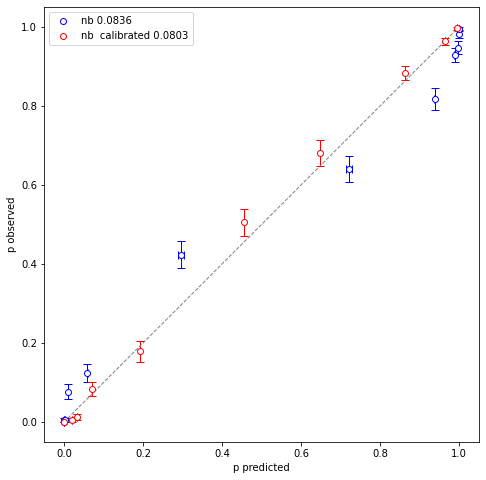

In [41]:
f = calibration_function(calibration_data.Gender=='Female', nb_cal_calibration_predicted_proba, n_bins=12)
nb_test_predicted_proba_cal = f(nb_cal_test_predicted_proba)
nb_cal_test_q_rd_calibrated = reliability_diagram(test_data.Gender=='Female', nb_test_predicted_proba_cal, n_bins=12, strategy='quantile')
fig, ax = reliability_diagram_plot()
brier_nb_cal = brier_score_loss(test_data.Gender=='Female', nb_test_predicted_proba_cal)
add_reliability_diagram(*nb_cal_test_q_rd, ax = ax, label='nb {:.4f}'.format(brier_nb) )
add_reliability_diagram(*nb_cal_test_q_rd_calibrated, ax = ax, label='nb  calibrated {:.4f}'.format(brier_nb_cal), color='red' )
ax.legend();

The output looks fairly good but please remember that we have discretized the response of the classifier into 12 values! Also the calibration  does not make classifier better at classification. Actually it can make it  worse, at least this method :( That's because the correction function is not a strictly increasing function. And indeed the calibrated classifier has slightly worse AUC score.

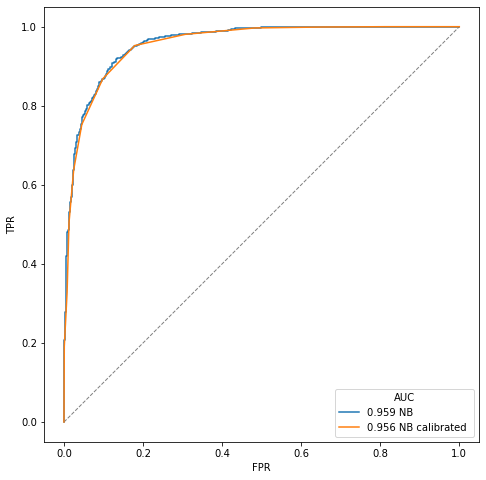

In [42]:
fig, ax = roc_plot()
add_roc_curve(test_data.Gender=='Female', nb_test_predicted_proba, "NB ", ax=ax)
add_roc_curve(test_data.Gender=='Female', nb_test_predicted_proba_cal, "NB calibrated", ax=ax)
ax.legend(title='AUC');

This can be corrected if we use more bins, but that means less points in each bin and so bigger errors. 

This is only a short introduction to the topic of calibrating the classifiers. There are of course more calibration  methods besides the one I have presented. The scikit-learn library contains class `CalibratedClassifierCV` that can perform calibration using two different methods. You can read more about it [here](https://scikit-learn.org/stable/modules/calibration.html#calibration). 